## Optimization
### Project 3 – Non-Linear Programming

In [5]:
import numpy as np
import pandas as pd
import gurobipy as gp
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model

In [6]:
# Reading the files
train_df = pd.read_csv('training_data.csv')
test_df = pd.read_csv('test_data.csv')

# Adding a column for the intercept
train_df.insert(1, column='X0', value=np.ones(len(train_df)))
test_df.insert(1, column='X0', value=np.ones(len(test_df)))

# Defining the feature space and target variable
X_train = np.array(train_df.iloc[:, 1:])
Y_train = np.array(train_df['y'])
X_test = np.array(test_df.iloc[:, 1:])
Y_test = np.array(test_df['y'])

In [7]:
train_df.head()

,y,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,8.536145,1.0,-1.535413,0.718888,-2.099149,-0.442842,-0.598978,-1.642574,0.207755,0.760642,...,0.361866,1.793098,-0.631287,-0.061751,0.511049,0.488754,-0.612772,-0.471045,-1.139781,-0.260773
1,4.808344,1.0,-1.734609,0.551981,-2.147673,-1.552944,1.514910,-1.143972,0.737594,1.321243,...,-0.677985,-0.165679,0.065405,0.137162,1.258197,-0.120834,-1.564834,-0.242565,-0.001827,1.187453
2,-1.530427,1.0,0.097257,0.107634,-0.194222,0.335454,-0.408199,0.133265,0.706179,0.394971,...,1.108801,0.333791,0.282055,-1.086294,-0.115354,0.257857,-0.088838,-0.751231,1.450609,0.290593
3,-0.428243,1.0,-0.067702,0.557836,0.700848,-1.121376,1.722274,0.613525,0.700909,-0.417976,...,0.692511,-0.350990,0.624558,0.434520,-0.367409,-1.144681,-0.136524,-0.557214,0.416303,0.484495
4,0.566694,1.0,0.488729,0.211483,0.568389,0.646837,0.163868,-0.002152,0.125137,0.493571,...,-0.000605,1.075280,0.182281,-1.138458,0.106092,0.544640,-0.383487,-0.425773,2.667647,-0.050748


In [8]:
TIME_LIMIT = 360  # Set the time limit per iteration
n_folds = 10  # Specify the number of folds for cross-validation
np.random.seed(seed=42)

1. The training data is randomly rearranged to ensure unbiased model training.
2. Features (characteristics) and the target variable (outcome) are separated for training and testing purposes.
3. K-fold indices are created, dividing the shuffled training data into 10 subsets for robust model evaluation. The printed indices show the training and testing data for the first fold.

In [9]:
# Randomly shuffle the training data
shuffled_train_indices = np.random.permutation(train_df.index)
shuffled_train_df = train_df.iloc[shuffled_train_indices]

# Separate the features (X) and target variable (y) for both training and test sets
X_train_shuffled, y_train_shuffled = shuffled_train_df.drop(columns='y').to_numpy(), shuffled_train_df['y'].to_numpy()
X_test, y_test = test_df.drop(columns='y').to_numpy(), test_df['y'].to_numpy()

# Generate k-fold indices
k_folds = 10
kfold_generator = KFold(n_splits=k_folds)
k_folds_dict = {}

for fold, (train_indices, test_indices) in enumerate(kfold_generator.split(X_train_shuffled)):
    k_folds_dict[fold] = {'train_indices': train_indices, 'test_indices': test_indices}

# Print the k-fold indices for the first fold
print(f"K-Fold Indices for the first fold: {k_folds_dict[0]}")


K-Fold Indices for the first fold: {'train_indices': array([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194,

In [10]:
# Define a range of options for the parameter 'K'
options_for_k = np.arange(5, 51, 5)

# Create an empty DataFrame to store Gurobi optimization results for different K values
gurobi_results = pd.DataFrame(index=k_folds_dict.keys(), columns=options_for_k)

# Initialize basic parameters for Gurobi optimization
M = 50  # A constant parameter
beta = X_train.shape[1] - 1  # Number of independent variables
v_type = ['C'] * (beta + 1) + ['B'] * beta  # Variable types: continuous for betas, binary for z variables
lower_bounds = [-M] * (beta + 1) + [0] * beta  # Lower bounds for variables


This function optimizes a regression model using Gurobi optimization, finding the best beta coefficients for a given k value. It uses mathematical constraints and objectives to balance the model complexity and accuracy. The result is a set of optimal beta coefficients, crucial for predicting outcomes from input data.

Constraints used:

1. **Sum of Independent Betas Constraint (`< k`):**
   - Purpose: Limits the total number of independent beta coefficients (excluding the intercept) to be less than or equal to a specified value, `k`.
   - Importance: Controls model complexity by restricting the number of predictor variables considered, preventing overfitting and enhancing generalization to new data.

2. **Big M Constraints (`< M` and `> -M`):**
   - Purpose: Enforces upper and lower bounds on each independent beta coefficient to balance precision and numerical stability.
   - Importance: These constraints prevent excessively large or small beta values, ensuring a stable optimization process and preventing numerical issues. They are crucial for the convergence and reliability of the optimization algorithm.

Overall, these constraints contribute to the creation of a well-regularized regression model by controlling the number of predictors and preventing extreme beta values, promoting a balance between model simplicity and accuracy.

In [11]:
from gurobipy import Model, GRB, quicksum
import numpy as np

def optimize_reg_model(X, y, k, time_limit=TIME_LIMIT):
    n_samples, n_features = X.shape

    # Create a new model
    model = Model("variable_selection_MIQP")

    # Set the time limit
    model.setParam('TimeLimit', time_limit)

    model.Params.OutputFlag = 0

    # Define the big-M. This should be sufficiently large to not restrict the beta values when zj=1.
    M = 10000

    # Add variables to the model
    beta = model.addVars(n_features, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="beta")
    z = model.addVars(n_features, vtype=GRB.BINARY, name="z")
    beta0 = model.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, name="beta0")

    # Set the objective function
    obj = quicksum((beta0 + quicksum(beta[j] * X[i, j] for j in range(n_features)) - y[i])**2 for i in range(n_samples))
    model.setObjective(obj, GRB.MINIMIZE)

    # Add constraints for variable selection
    for j in range(n_features):
        model.addConstr(beta[j] <= M * z[j], "upper_bound_{}".format(j))
        model.addConstr(beta[j] >= -M * z[j], "lower_bound_{}".format(j))

    # Constraint on the number of selected variables
    model.addConstr(z.sum() <= k, "k_features")

    # Optimize the model
    model.optimize()

    # Return the optimal values of beta and beta0 in a list
    return np.array([beta0.X] + [beta[j].X for j in range(n_features)]), k


In [12]:
def optimize_regression_model(X, y, k):
    """Obtain the optimal beta coefficients using Gurobi optimization for a given k value.
    Inputs: X and y data as numpy arrays, and the k value.
    """

    # Create matrices for quadratic and linear objective functions
    quadratic_obj = np.zeros(shape=(2 * beta + 1, 2 * beta + 1))
    quadratic_obj[:(beta + 1), :(beta + 1)] = X.T @ X
    linear_obj = np.zeros(shape=beta * 2 + 1)
    linear_obj[:(beta + 1)] = -2 * y.T @ X

    # Initialize lists for constraints
    sense = []
    b = []

    # Set up constraints to ensure the number of independent betas is <= k
    num_constraints = beta * 2 + 1
    A = np.zeros(shape=(num_constraints, len(linear_obj)))

    # Constraint for the sum of independent betas <= k (excluding the intercept beta)
    A[0, (beta + 1):] = 1
    sense.append('<')
    b.append(k)

    # Add big M constraints
    row_index = 1
    for i in range(1, beta + 1):
        # Set constraint that beta must be less than M
        A[row_index, i] = 1
        A[row_index, i + beta] = -M
        sense.append('<')
        b.append(0)
        row_index += 1

        # Set constraint that beta must be greater than -M
        A[row_index, i] = 1
        A[row_index, i + beta] = M
        sense.append('>')
        b.append(0)

        row_index += 1

    # Solve using Gurobi
    regression_model = gp.Model()
    regression_vars = regression_model.addMVar(len(linear_obj), lb=lower_bounds, vtype=v_type)
    regression_constraints = regression_model.addMConstr(A, regression_vars, sense, b)
    regression_model.setMObjective(quadratic_obj, linear_obj, 0, sense=gp.GRB.MINIMIZE)
    regression_model.Params.OutputFlag = 0
    regression_model.Params.TimeLimit = TIME_LIMIT
    regression_model.optimize()

    # Return the optimal beta coefficients
    return regression_vars.x[:(beta + 1)]


In [13]:
def predict_y_values(X, beta_coefficients):
    """Generate predicted y values based on input features and beta coefficients."""
    return X @ beta_coefficients

def calculate_sum_of_squared_errors(actual_values, predicted_values):
    """Compute the sum of squared errors between actual and predicted y values."""
    return sum((actual_values - predicted_values)**2)


This code performs k-fold cross-validation to assess a Gurobi-based regression model's performance with varying predictor counts (`k`). It optimizes beta coefficients, calculates validation mean squared error, and records results for analysis, aiding in predictor selection and model evaluation. The outcomes are stored in a CSV file and displayed for insights.

In [14]:
# Iterate through each fold in the k-fold cross-validation
for fold_index, indices_dict in k_folds_dict.items():

    # Extract training and testing sets for the current fold
    X_train_fold, y_train_fold = X_train[indices_dict['train_indices']], Y_train[indices_dict['train_indices']]
    X_test_fold, y_test_fold = X_train[indices_dict['test_indices']], Y_train[indices_dict['test_indices']]

    # Evaluate different values of k for the Gurobi optimization
    for k_value in options_for_k:
        # Solve Gurobi optimization to find optimal betas
        optimal_betas = optimize_regression_model(X_train_fold, y_train_fold, k_value)

        # Calculate validation mean squared error
        validation_mse = calculate_sum_of_squared_errors(y_test_fold, predict_y_values(X_test_fold, optimal_betas))

        # Store the validation MSE in the results dataframe
        gurobi_results.loc[fold_index, k_value] = validation_mse  

# Save the results to a CSV file
gurobi_results.to_csv('gurobi_sse_results.csv', index=False)

# Display the Gurobi results dataframe
gurobi_results


Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-20


,5,10,15,20,25,30,35,40,45,50
0,83.840984,65.654167,61.542818,65.669135,71.742373,70.293239,69.856251,66.751928,69.013206,68.820413
1,103.882987,80.720307,78.791397,77.909288,80.424732,84.166349,84.105088,87.451633,85.014725,84.915003
2,93.95176,83.426646,83.556876,86.37487,78.946073,81.718949,80.01959,82.360461,82.833008,82.540397
3,112.521598,81.066425,78.709721,84.02203,75.150536,82.956636,78.314968,79.493286,77.720541,77.60686
4,58.147479,43.941457,45.519743,50.56826,48.385274,53.479931,53.551701,57.3041,56.922792,57.797009
5,62.955212,61.700393,69.10298,70.231391,63.3488,75.438984,70.736718,68.912212,70.003181,69.590721
6,58.176295,62.082058,66.941552,71.573519,70.456066,74.255808,74.274426,79.103353,79.199265,80.518896
7,153.755185,98.307875,99.603258,100.978873,96.868892,105.469515,111.488303,110.097776,114.031482,112.127434
8,93.689227,62.175796,87.152824,95.271161,95.469862,112.836501,116.060835,127.204931,123.719999,124.22228
9,96.558334,85.712508,93.128767,93.938618,89.690219,89.466602,92.696127,88.664071,88.904964,89.045533


In [15]:
sse_per_fold = gurobi_results.sum()
pd.DataFrame(sse_per_fold,columns=['Total SSE'])


,Total SSE
5,917.479061
10,724.787631
15,764.049938
20,796.537143
25,770.482828
30,830.082514
35,831.104008
40,847.343751
45,847.363163
50,847.184545


Text(0, 0.5, 'Aggregate SSE Across All Folds')

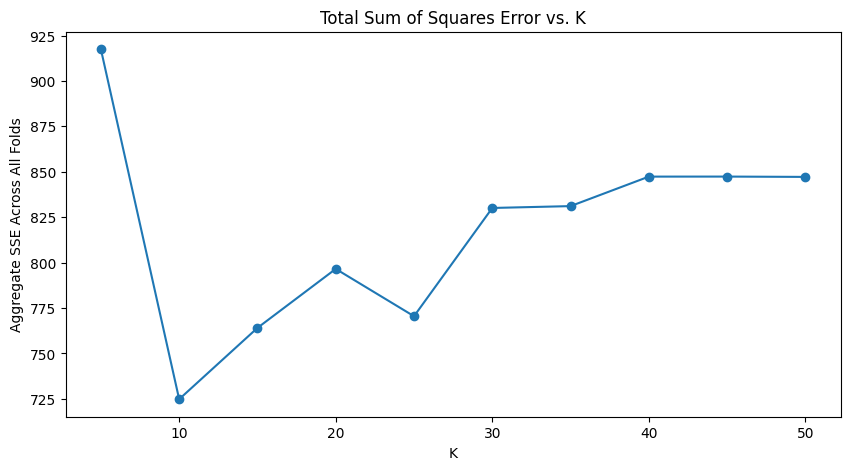

In [16]:
# Plotting the Total Sum of Squares Error by varying K values
sse_per_fold.plot(figsize=(10, 5), marker='o')
plt.title('Total Sum of Squares Error vs. K')
plt.xlabel('K')
plt.ylabel('Aggregate SSE Across All Folds')


In [17]:
# Identify the best-performing K for later reference
best_k = int(sse_per_fold.sort_values().index[0])
print(f'The optimal K value is {best_k}')

The optimal K value is 10


In [18]:
# Fit the model with the best K on the entire dataset and evaluate on the holdout set
best_results = pd.DataFrame(columns=['SSE', 'MSE', 'R_Squared'])

# Create and train the model using the best K
best_gurobi_betas = optimize_regression_model(X_train, Y_train, k=best_k)

# Make predictions on the holdout set
gurobi_predictions = predict_y_values(X_test, best_gurobi_betas)

# Calculate performance metrics
gurobi_sse = calculate_sum_of_squared_errors(y_test, gurobi_predictions)
gurobi_mse = mean_squared_error(y_test, gurobi_predictions)
gurobi_r_squared = r2_score(y_test, gurobi_predictions)


In [19]:
best_results.loc['Gurobi_Method'] = [gurobi_sse, gurobi_mse, gurobi_r_squared]
best_results

,SSE,MSE,R_Squared
Gurobi_Method,116.827198,2.336544,0.858668


The optimal K value, 10, was determined through cross-validation. For the Gurobi-based regression method, the results indicate a Sum of Squared Errors (SSE) of 116.83, a Mean Squared Error (MSE) of 2.34, and a high R-squared value of 0.86. These metrics suggest the model's effectiveness in explaining the variability in the data, with lower MSE and higher R-squared values indicating better performance.

### Question 4:
Use scikit learn to do 10-fold cross validation on the training set to pick 𝜆 for LASSO.
Once you find the best value of 𝜆, fit a LASSO model to the entire training set using that
value of 𝜆. With the 𝛽s you find in that LASSO model make a prediction of the y values
in the test set.

In [20]:
lasso_model_cv = linear_model.LassoCV(cv=10).fit(X_train,Y_train)
best_lambda = lasso_model_cv.alpha_
print(f'The best lambda = {best_lambda}')

The best lambda = 0.07638765995113507


In [21]:
# Train the LASSO model with the selected lambda
lasso_model = Lasso(best_lambda).fit(X_train, Y_train)

# Generate predictions on the holdout set and capture key metrics
lasso_predictions = lasso_model.predict(X_test)
lasso_sse = calculate_sum_of_squared_errors(y_test, lasso_predictions)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
lasso_r_squared = r2_score(y_test, lasso_predictions)

# Record LASSO metrics in the best results dataframe
best_results.loc['Lasso_Metrics'] = [lasso_sse, lasso_mse, lasso_r_squared]


In [22]:
best_results

,SSE,MSE,R_Squared
Gurobi_Method,116.827198,2.336544,0.858668
Lasso_Metrics,117.481738,2.349635,0.857876


The Gurobi Method slightly outperforms the Lasso Method in terms of SSE and MSE, with lower values indicating better predictive accuracy. However, both methods demonstrate a comparable R-Squared value of approximately 0.86, suggesting a similar ability to explain the variability in the data.

In summary, while the Gurobi Method marginally excels in certain error metrics, both methods exhibit strong performance in capturing and explaining the underlying patterns in the dataset.

In [23]:
# Count the non-zero coefficients in the Lasso model
lasso_betas_count = (lasso_model.coef_ != 0).sum()
print(f'Number of non-zero coefficients with Lasso method: {lasso_betas_count}')

# Count the non-zero coefficients in the Gurobi Optimization method (excluding intercept)
gurobi_betas_count = (best_gurobi_betas != 0).sum() - 1
print(f'Number of non-zero coefficients with Gurobi Optimization method: {gurobi_betas_count}')


Number of non-zero coefficients with Lasso method: 17
Number of non-zero coefficients with Gurobi Optimization method: 10


We are comparing the number of non-zero coefficients, or 'betas,' identified by two different methods for variable selection. The Lasso method resulted in 17 non-zero betas, indicating the features that significantly contribute to the model. On the other hand, the Gurobi Optimization method identified 10 non-zero betas (excluding the intercept), offering an alternative perspective on the essential variables for our predictive model. This comparison helps us understand the varying emphasis on features selected by each method and their potential impact on model interpretability and performance.

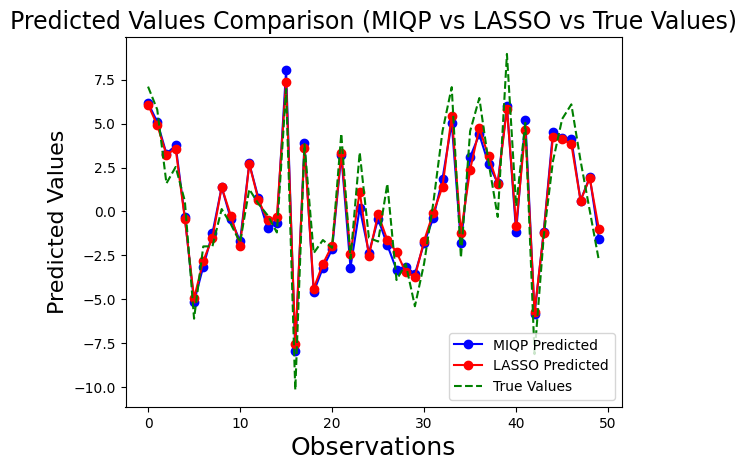

In [24]:
import numpy as np
import matplotlib.pyplot as plt

lasso_predictions = lasso_model.predict(X_test)
gurobi_predictions = predict_y_values(X_test, best_gurobi_betas)
true_values = Y_test  

X = np.arange(len(true_values))

# Configure the plot
fig, ax = plt.subplots()

ax.plot(X, gurobi_predictions, marker='o', linestyle='-', color='b', label='MIQP Predicted')
ax.plot(X, lasso_predictions, marker='o', linestyle='-', color='r', label='LASSO Predicted')
ax.plot(X, true_values, linestyle='--', color='g', label='True Values')  # Green dashed line for true values

ax.legend()
plt.title("Predicted Values Comparison (MIQP vs LASSO vs True Values)", fontsize=17)
plt.xlabel('Observations', fontsize=18)
plt.ylabel('Predicted Values', fontsize=16)

# Show the plot
plt.show()


In [25]:
# Extract Gurobi beta values
Gurobi = {f'x{i + 1}': best_gurobi_betas[i] for i in range(50)}
Gurobi

{'x1': 0.9725240765514857,
 'x2': 0.0,
 'x3': 0.0,
 'x4': 0.0,
 'x5': 0.0,
 'x6': 0.0,
 'x7': 0.0,
 'x8': 0.0,
 'x9': 0.0,
 'x10': -2.3082072619383487,
 'x11': 0.0,
 'x12': 0.0,
 'x13': 0.0,
 'x14': 0.0,
 'x15': 0.0,
 'x16': -0.5183261233652069,
 'x17': -0.20416201346654447,
 'x18': 0.0,
 'x19': 0.0,
 'x20': 0.0,
 'x21': 0.0,
 'x22': 0.0,
 'x23': 0.0,
 'x24': -1.5591431785888525,
 'x25': 0.8669733628924519,
 'x26': 0.0,
 'x27': -1.3119194151226834,
 'x28': 0.0,
 'x29': 0.0,
 'x30': 0.0,
 'x31': 0.0,
 'x32': 0.0,
 'x33': 0.0,
 'x34': 0.0,
 'x35': 0.4081653033058824,
 'x36': 0.0,
 'x37': 0.0,
 'x38': 0.0,
 'x39': 0.0,
 'x40': 0.0,
 'x41': 0.0,
 'x42': 0.0,
 'x43': 0.0,
 'x44': 0.0,
 'x45': 0.0,
 'x46': 1.7814748910764724,
 'x47': 0.0,
 'x48': 0.8873829240125517,
 'x49': -0.28229212764205946,
 'x50': 0.0}

In [26]:
# Extract LASSO beta values
lasso = {f'x{i + 1}': lasso_model.coef_[i] for i in range(len(lasso_model.coef_)-1)}
lasso

{'x1': 0.0,
 'x2': -0.0,
 'x3': -0.0,
 'x4': 0.0,
 'x5': 0.0,
 'x6': -0.0,
 'x7': 0.0,
 'x8': -0.0,
 'x9': -0.0,
 'x10': -2.16054764522603,
 'x11': 0.0,
 'x12': -0.059640310981349004,
 'x13': -0.0,
 'x14': -0.0,
 'x15': -0.0,
 'x16': -0.4191248440754299,
 'x17': -0.19325407849784232,
 'x18': 0.0,
 'x19': 0.0,
 'x20': -0.0,
 'x21': 0.0,
 'x22': 0.0,
 'x23': -0.1951775896463753,
 'x24': -1.3638873751930642,
 'x25': 0.7425965005682691,
 'x26': -0.0,
 'x27': -1.3048157442977073,
 'x28': -0.0,
 'x29': 0.0,
 'x30': 0.05798283048603739,
 'x31': 0.0,
 'x32': -0.0,
 'x33': 0.0,
 'x34': -0.09737838635372817,
 'x35': 0.28341628683345627,
 'x36': 0.0,
 'x37': 0.0,
 'x38': 0.0,
 'x39': 0.0,
 'x40': -0.23157872750798247,
 'x41': 0.0,
 'x42': -0.0,
 'x43': 0.0,
 'x44': 0.0,
 'x45': 0.03078191204040862,
 'x46': 1.5636217156019878,
 'x47': -0.021600326247110467,
 'x48': 0.6999244711955708,
 'x49': -0.09289744743686554,
 'x50': 0.0}

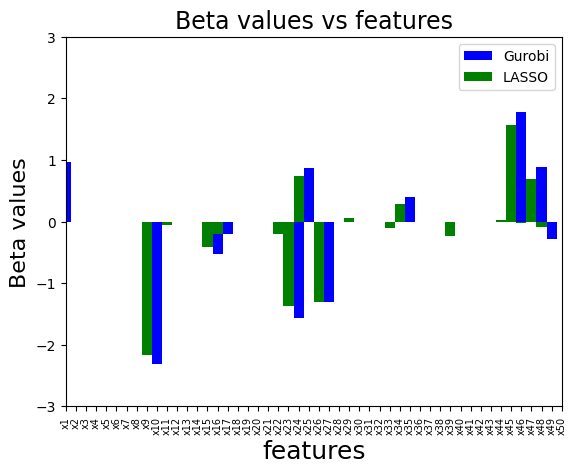

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Set up data for plotting
X = np.arange(len(Gurobi))
width = 1

# Configure the plot
fig, ax = plt.subplots()
ax.set_xlim(0, 0.001)
ax.set_ylim(-3, 3)

# Create bar plots for Gurobi and LASSO
ax.bar(X, Gurobi.values(), width=width, color='b', align='center')
ax.bar(X - 1, lasso.values(), width=width, color='g', align='center')

# Add legends and labels
ax.legend(('Gurobi', 'LASSO'))
plt.xticks(X, lasso.keys())
plt.title("Beta values vs features", fontsize=17)
plt.xlabel('features', fontsize=18)
plt.ylabel('Beta values', fontsize=16)
plt.xticks(fontsize=7, rotation=90)

# Show the plot
plt.show()


Presented here is a comparative bar graph illustrating the 𝞫 coefficients for MIQP and LASSO variable selections. As elaborated in prior sections, it is evident that LASSO identifies 17 significant features, while MIQP identifies only 10, with the majority of non-intercept betas falling within the [-2, 2] range. Furthermore, noteworthy differences exist in the important features identified by each method: certain features deemed crucial for predicting Y using MIQP may not hold the same significance for LASSO, or they may exhibit different signs. For instance, X1 emerges as an important predictor in the MIQP model but possesses a beta value of 0 in the LASSO model. Conversely, X8, which is crucial in predicting Y in the LASSO model, has a beta value of 0 in the MIQP model. Additionally, X24 exhibits a positive beta value in the MIQP model but a negative beta value in the LASSO model.

In summary, while MIQP, as a direct variable selection method, enhances test set accuracy, it comes at the expense of increased computational demands and longer processing times, potentially posing challenges with larger datasets. The MIQP method also necessitates a more intricate manual setup, lacking the convenience of well-established libraries like Scikit-learn, which incorporates a diverse array of machine learning algorithms. Moreover, MIQP may face challenges associated with local optima, depending on the complexity of the problem. On the other hand, LASSO excels in automating variable selection through weight decay, mitigating overfitting by shrinking coefficients toward zero. However, its feature selection may introduce bias and arbitrariness, especially when choosing one feature from a set of highly multi-collinear features. LASSO's performance might be surpassed by other regularization techniques like Ridge or ElasticNet, and it may not perform as effectively with high-dimensional data (where n << p).

In our thorough analysis, considering the advantages and drawbacks of each method, we strongly advise against relying solely on one approach. The choice of the method should align with the specific use case, taking into account our business needs and technical capabilities. It's crucial to weigh various factors when deciding on the model.

LASSO proves advantageous when:
a) Computational resources are limited, and a quick turnaround time is essential.
b) The model needs frequent updating, such as weekly data refreshes, as LASSO significantly saves time and computational resources.
c) It comes neatly packaged, making implementation straightforward. Even individuals with limited coding experience can efficiently use it.
d) It's an open-source solution, in contrast to Gurobi, which requires a purchase for MIQP implementation.

MIQP may be the preferred choice when:
a) Abundant computational power is available, and time constraints are not a significant factor.
b) A predetermined number of features must be selected.
c) The goal is to explain most of the variance in the target variable with a minimal, specified set of features, especially when acquiring additional data for more features is costly.

In summary, if a model doesn't require frequent runs and computational power is not a constraint, MIQP may offer an advantage over LASSO in terms of model performance and generalization. However, it comes with computational expenses and coding complexity. Given the trade-offs between computational efficiency, desired error margins, and deployment complexity, a thoughtful discussion is essential to determine the most suitable feature selection method for our business objectives.